# DeepInsight SqueezeNet Example

This example shows a case of using the output of 
pyDeepInsight.ImageTransformer to train a SqueezeNet model
using PyTorch. This follows the general approach used in the
original DeepInsight paper.

## DeepInsight

In [9]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <D9493EF5-8DAB-3A5D-85D5-684F04544B84> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <ECC148AF-20FF-3EEE-BC75-4DD3E7455393> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


Load example TCGA data and split into training and testing sets

In [10]:
expr_file = r"./curatedTCGAData_RNASeq2GeneNorm-20160128.txt"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['cancer'].values
X = expr.iloc[:, 2:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

In [11]:
np.unique(y, return_counts=True)

(array(['BRCA', 'HNSC', 'KIRC', 'LGG', 'LUAD', 'LUSC', 'THCA'],
       dtype=object),
 array([1093,  520,  533,  516,  515,  501,  501]))

Normalize data using LogScaler and encode classes

In [12]:
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

In [13]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

Create umap object

In [8]:
import umap.umap_ as umap

# Set up UMAP for dimensionality reduction
distance_metric = 'cosine'
reducer = umap.UMAP(
    n_components=2,        # Number of dimensions to reduce to
    metric=distance_metric, # Distance metric
    init='random',          # Initialization method
    n_jobs=-1               # Use all available cores for computation
)

Initialize image transformer.

In [14]:
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

Train image transformer on training data and transform training 
and testing sets. Values should be between 0 and 1.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


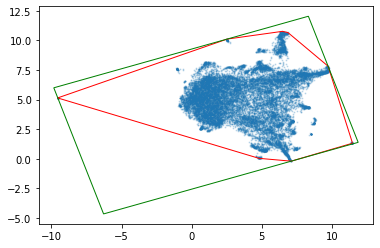

In [15]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap.

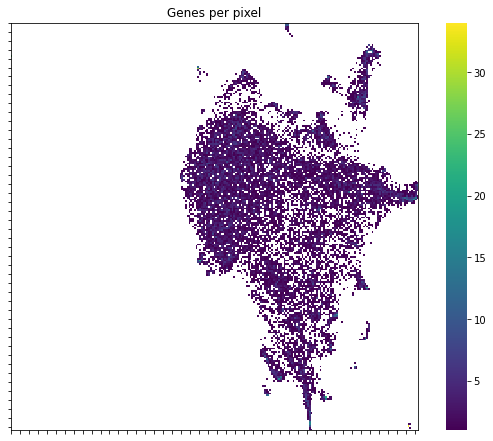

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel")

The following are showing plots for the image matrices first four samples 
of the training set. 

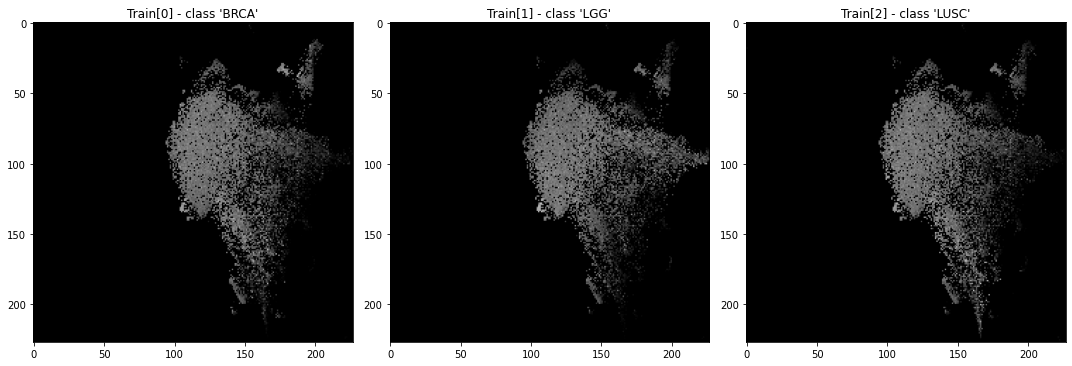

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

Transforming the testing data is done the same as transforming the 
training data.

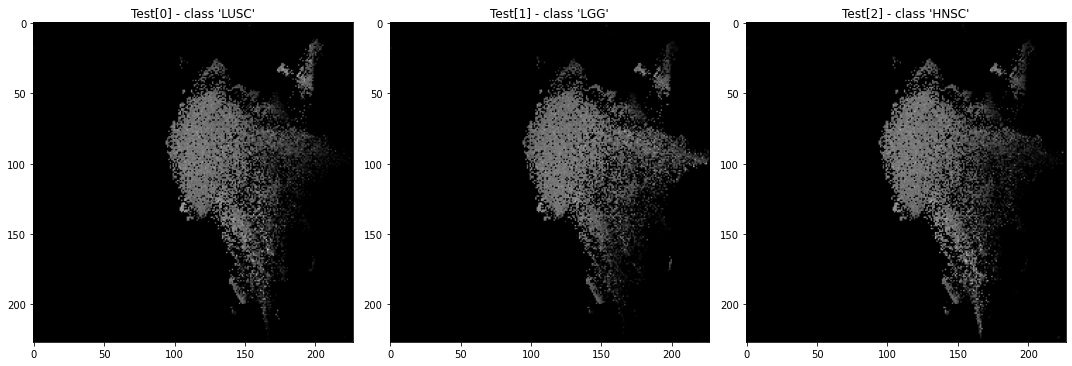

In [18]:
X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text(f"Test[{i}] - class '{y_test[i]}'")
plt.tight_layout()

## SqueezeNet

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import warnings; 
warnings.simplefilter('ignore')

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Modify [PyTrorch SqueezeNet 1.1][1] output to number of classes

[1]: https://pytorch.org/vision/stable/models/squeezenet.html

In [21]:
model = torchvision.models.squeezenet1_1(weights='DEFAULT')
model.classifier.append(nn.Flatten())
_ = model.classifier.append(nn.Linear(1000, num_classes))

Transform numpy image format to PyTorch tensor. Using an untrained network,
so normalization as specificed in SqueezeNet documentation is not 
required.


In [22]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [23]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor = torch.from_numpy(le.transform(y_test))

Generate pyTorch datasets and dataloaders for training and testing sets.

In [24]:
batch_size = 200

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

Train SqueezeNet for 100 epochs

In [26]:
model.train()
model.to(device)
for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')

[0] loss: 2.161
[20] loss: 0.093
[40] loss: 0.037
[60] loss: 0.027
[80] loss: 0.010
[99] loss: 0.015


Calculate accuracy of prediction

In [27]:
model.to('cpu')
model = model.eval()

In [28]:
with torch.no_grad():
    y_hat = model(X_train_tensor)
train_predicted = torch.max(y_hat, 1)[1]

In [29]:
with torch.no_grad():
    y_hat = model(X_test_tensor)
test_predicted = torch.max(y_hat, 1)[1]

In [30]:
print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor):.3f}")

The train accuracy was 0.999
The test accuracy was 0.962


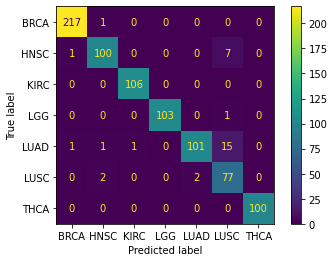

In [31]:
_ = ConfusionMatrixDisplay.from_predictions(test_predicted, y_test_tensor, display_labels=le.classes_)